In [1]:
import collections
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

41631744/41625533 [==============================]41631744/41625533 [==============================] - 4s 0us/step

40689664/40688441 [==============================]40689664/40688441 [==============================] - 4s 0us/step



In [3]:
#Building the Input Pipeline
def _parse_function(record):
    #Extract features and labels
    #Return: A tuple (labels, features)
    
    features = {
        'terms': tf.VarLenFeature(dtype=tf.string), #terms are strings of varying lengths
        'labels': tf.FixedLenFeature(shape=[1], dtype=tf.float32) #labels are 0 and 1
    }
    
    parsed_features = tf.parse_single_example(record, features)
    
    terms = parsed_features['terms'].values
    labels = parsed_features['labels']
    
    return {'terms': terms}, labels

In [4]:
#Create the Dataset object
ds = tf.data.TFRecordDataset(train_path)
#Map features and labels with the parse function
ds = ds.map(_parse_function)

ds

<MapDataset shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

In [5]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
         b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
         b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
         b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
         b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
         b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
         b'!', b')', b'sascha', b'is', b'played', b'very', b'well', b'by',
         b'joanna', b'pacula', b',', b'but', b'she', b'needed', b'more',
         b'lines', b'than', b'she', b'was', b'given', b',', b'her',
         b'character', b'needed', b'to', b'be', b'developed', b'.',
         b'there', b'are', b'way', b'too', b'many', b'men', b'in', b'this',
         b'story', b',', b'there', b'is', b'zero', b'romance', b',', b'too',
         b'much', b'action', b',', b'and', b'way', b'too', b'dumb', b'of',
         b'an', b'ending', b'.', b'

In [6]:
#Create an input_function that parses the tf.examples from the given files
#and split them into features and targets
def _input_function(input_filenames, num_epochs=None, shuffle=True):
    
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    #Our feature data is variable-length, so pad and batch
    #each field of the dataset structure to whatever size is necessary
    ds = ds.padded_batch(25, ds.output_shapes)
    
    ds = ds.repeat(num_epochs)
    
    #Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels


Use a Linear Model with Sparse Inputs and an Explicit Vocabulary

In [7]:
#50 informative terms that compose our model vocabulary
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key='terms', vocabulary_list=informative_terms)
terms_feature_column

_VocabularyListCategoricalColumn(key='terms', vocabulary_list=('bad', 'great', 'best', 'worst', 'fun', 'beautiful', 'excellent', 'poor', 'boring', 'awful', 'terrible', 'definitely', 'perfect', 'liked', 'worse', 'waste', 'entertaining', 'loved', 'unfortunately', 'amazing', 'enjoyed', 'favorite', 'horrible', 'brilliant', 'highly', 'simple', 'annoying', 'today', 'hilarious', 'enjoyable', 'dull', 'fantastic', 'poorly', 'fails', 'disappointing', 'disappointment', 'not', 'him', 'her', 'good', 'time', '?', '.', '!', 'movie', 'film', 'action', 'comedy', 'drama', 'family'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

Construct Linear Classifier and train

In [12]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]
print(feature_columns)

classifier = tf.estimator.LinearClassifier(feature_columns=feature_columns, optimizer=my_optimizer)

classifier.train(input_fn=lambda: _input_function([train_path]), steps=1000)

evaluation_metrics = classifier.evaluate(input_fn=lambda: _input_function([train_path]), steps=1000)

print('Training set metrics: ')
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print('------------------')

evaluation_metrics = classifier.evaluate(input_fn=lambda: _input_function([test_path]), steps=1000)

print('Test set metrics: ')
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print('-----------------')

[_VocabularyListCategoricalColumn(key='terms', vocabulary_list=('bad', 'great', 'best', 'worst', 'fun', 'beautiful', 'excellent', 'poor', 'boring', 'awful', 'terrible', 'definitely', 'perfect', 'liked', 'worse', 'waste', 'entertaining', 'loved', 'unfortunately', 'amazing', 'enjoyed', 'favorite', 'horrible', 'brilliant', 'highly', 'simple', 'annoying', 'today', 'hilarious', 'enjoyable', 'dull', 'fantastic', 'poorly', 'fails', 'disappointing', 'disappointment', 'not', 'him', 'her', 'good', 'time', '?', '.', '!', 'movie', 'film', 'action', 'comedy', 'drama', 'family'), dtype=tf.string, default_value=-1, num_oov_buckets=0)]
Training set metrics: 
loss 11.286292
label/mean 0.5
accuracy 0.78864
average_loss 0.4514517
auc 0.872044
auc_precision_recall 0.86402076
accuracy_baseline 0.5
global_step 1000
prediction/mean 0.4843388
------------------
Test set metrics: 
loss 11.290888
label/mean 0.5
accuracy 0.78508
average_loss 0.4516355
auc 0.8706503
auc_precision_recall 0.86215484
accuracy_baseli

DNN Model

In [13]:
classifier = tf.estimator.DNNClassifier(feature_columns=[tf.feature_column.indicator_column(terms_feature_column)],
                                       hidden_units=[20,20],
                                       optimizer=my_optimizer)

try:
    classifier.train(input_fn=lambda: _input_function([train_path]), steps = 1000)
    evaluation_metrics = classifier.evaluate(input_fn=lambda: _input_function([train_path]), steps = 1)
    
    print('Training set metrics: ')
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print('-----------------------')
    
    evaluation_metrics = classifier.evaluate(input_fn=lambda: _input_function([test_path]), steps = 1)
    
    print('Test set metrics: ')
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print('------------------------')
except ValueError as err:
    print(err)

Training set metrics: 
loss 13.91305
label/mean 0.36
accuracy 0.68
average_loss 0.556522
auc 0.86805546
auc_precision_recall 0.79908
accuracy_baseline 0.64
global_step 1000
prediction/mean 0.5630613
-----------------------
Test set metrics: 
loss 7.3404303
label/mean 0.6
accuracy 0.88
average_loss 0.29361722
auc 0.95333326
auc_precision_recall 0.969664
accuracy_baseline 0.6
global_step 1000
prediction/mean 0.56120723
------------------------


Use an Embedding with a DNN Model|

In [38]:
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=3)
feature_columns = [terms_embedding_column]

print(terms_feature_column)
print('-')
print(terms_embedding_column)
print('-')
print(feature_columns)

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns, hidden_units=[20,20], optimizer=my_optimizer)



classifier.train(input_fn = lambda: _input_function([train_path]), steps = 1000)
evaluation_metrics = classifier.evaluate(input_fn=lambda: _input_function([train_path]), steps = 1000)

print('Training set metrics: ')
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print('------------------------')

evaluation_metrics = classifier.evaluate(input_fn=lambda: _input_function([test_path]), steps = 1000)

print('Test set metrics: ')
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print('------------------------')



_VocabularyListCategoricalColumn(key='terms', vocabulary_list=('bad', 'great', 'best', 'worst', 'fun', 'beautiful', 'excellent', 'poor', 'boring', 'awful', 'terrible', 'definitely', 'perfect', 'liked', 'worse', 'waste', 'entertaining', 'loved', 'unfortunately', 'amazing', 'enjoyed', 'favorite', 'horrible', 'brilliant', 'highly', 'simple', 'annoying', 'today', 'hilarious', 'enjoyable', 'dull', 'fantastic', 'poorly', 'fails', 'disappointing', 'disappointment', 'not', 'him', 'her', 'good', 'time', '?', '.', '!', 'movie', 'film', 'action', 'comedy', 'drama', 'family'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
-
_EmbeddingColumn(categorical_column=_VocabularyListCategoricalColumn(key='terms', vocabulary_list=('bad', 'great', 'best', 'worst', 'fun', 'beautiful', 'excellent', 'poor', 'boring', 'awful', 'terrible', 'definitely', 'perfect', 'liked', 'worse', 'waste', 'entertaining', 'loved', 'unfortunately', 'amazing', 'enjoyed', 'favorite', 'horrible', 'brilliant', 'highly', 'simp

In [39]:
#Check that the model is actually using an embedding inside
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

In [40]:
# print(classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights'))
print(classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape)

(50, 3)


Examine the embedding

In [41]:
embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')
embedding_matrix

array([[ 0.52848905,  1.295306  , -0.9090037 ],
       [-0.08747127, -0.9926694 ,  0.33424598],
       [ 0.01428877, -1.0069083 , -0.3438132 ],
       [-1.1760284 ,  1.6853578 , -0.52972025],
       [ 0.3562083 , -0.407105  , -0.02225521],
       [ 1.6500574 ,  0.21618815,  0.8708597 ],
       [ 0.95665956, -0.71573406,  0.97566926],
       [-1.0341475 ,  0.70706576, -0.30251834],
       [-1.2928112 ,  0.6252844 , -0.56411827],
       [-1.0403339 ,  1.7760284 ,  0.02228029],
       [-0.8405694 ,  1.4910756 ,  0.05433732],
       [ 0.44664755, -0.37309033,  1.2630348 ],
       [ 0.5674382 , -0.96003926,  0.99112636],
       [ 0.7020242 , -0.3862042 , -0.5418567 ],
       [-1.1981572 ,  0.8910833 , -0.09491402],
       [-1.3314266 ,  2.210255  ,  0.04624909],
       [-0.44229287, -0.6500999 ,  0.4171659 ],
       [ 0.32885712, -0.9643717 ,  0.3455214 ],
       [-0.24900496,  0.7416441 , -0.6276513 ],
       [-0.04220327, -1.5357901 ,  0.9945896 ],
       [ 1.4576039 , -0.18948996, -0.088

In [83]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

#Rotate graph in 3D
%matplotlib notebook 

<IPython.core.display.Javascript object>


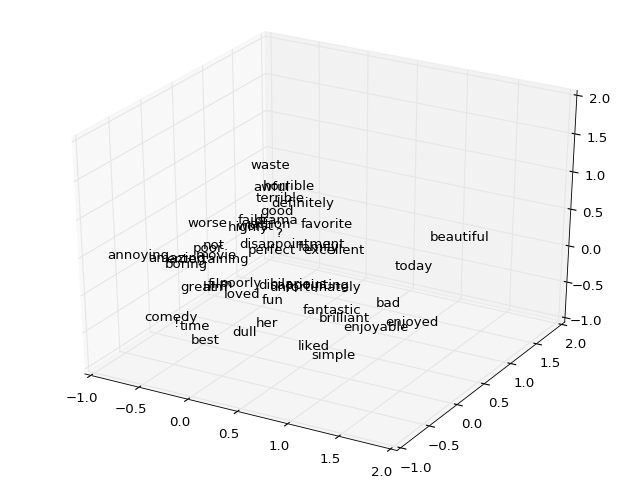

In [84]:
fig = plt.figure()
ax = Axes3D(fig)

for term_index in range(len(informative_terms)):
    #Create a one-hot encoding for our term. It has 0s every where except for a single 1 in the coordinate that corresponds to that term
    term_vector = np.zeros(len(informative_terms))
    term_vector[term_index] = 1
#     print(term_vector)
    #We will now project that one hot vector into the embedding space
    embedding_xy = np.matmul(term_vector, embedding_matrix)
#     print(embedding_xy)
#     plt.text(embedding_xy[0],
#              embedding_xy[1],
#              embedding_xy[2],
#              informative_terms[term_index])

#     ax.scatter(xs=embedding_xy[0], ys=embedding_xy[1], zs=embedding_xy[2], s=informative_terms[term_index])
    ax.text(x=embedding_xy[0], y=embedding_xy[1], z=embedding_xy[2],s=informative_terms[term_index])
    
    
    #Do a little setup to make sure the plot display nicely
# plt.rcParams['figure.figsize'] = (10,10)
# plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
# plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())

ax.set_xlim3d(-1,2)
ax.set_ylim3d(-1,2)
ax.set_zlim3d(-1,2)

plt.show()

Improve the model''s performance

In [99]:
informative_terms_url ='https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt'
informative_terms_path = tf.keras.utils.get_file(informative_terms_url.split('/')[-1], informative_terms_url)
with open(informative_terms_path, 'r', encoding="utf8") as f:
    #Convert it to a set first to remove duplicates
    informative_terms = list(set(f.read().split()))
print(informative_terms)

['spring', 'ghoulies', 'ignorant', 'towns', 'ralli', "brady's", 'vis', 'sees', 'vivian', 'mustn', 'propriety', 'brutal', 'magically', 'racist', 'cramer', 'dangerfield', 'revolved', 'hiphop', 'hamm', 'disowned', 'carrieanne', 'prim', 'baton', 'temper', 'lew', 'prompting', 'verne', 'obiwan', 'unsatisfactory', 'improving', 'goodrich', 'fizzles', 'workout', 'machine', 'treacherous', 'anglo', 'underpinnings', 'habits', 'repeatedly', 'oneself', 'spear', 'nurtured', 'punks', "woody's", "cage's", 'jeon', 'fanning', 'doubles', 'personal', 'alexis', 'chomsky', 'tender', 'undergoes', "rock's", 'clovis', 'provo', 'superego', 'count', 'sighing', 'jumbo', 'fandom', 'thrillers', 'cutouts', 'corrine', 'firth', 'technologically', 'documenting', 'abbreviated', 'jory', 'timeline', 'nauseum', 'solid', 'armor', 'revisit', 'foods', 'shaq', 'apologize', 'conceal', "akshay's", 'dying', 'communism', 'franchise', 'liam', 'freezing', 'slapdash', 'springsteen', 'vents', 'crashing', 'intruding', 'swingers', 'ching

In [102]:
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key='terms', 
                                                                                 vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=3)
feature_columns = [terms_embedding_column]
# print(terms_embedding_column)

#optimizer
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns, hidden_units=[10, 10], optimizer=my_optimizer)

classifier.train(input_fn=lambda: _input_function([train_path]), steps=1000)
evaluation_metrics = classifier.evaluate(input_fn=lambda: _input_function([train_path]), steps=1000)

print('Training metrics: ')
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print('----------------------------')

evaluation_metrics = classifier.evaluate(input_fn=lambda: _input_function([test_path]), steps=1000)

print('Test metrics: ')
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
print('-----------------------------')

Training metrics: 
loss 10.075381
label/mean 0.5
accuracy 0.83636
average_loss 0.40301523
auc 0.9072288
auc_precision_recall 0.90576285
accuracy_baseline 0.5
global_step 1000
prediction/mean 0.43634278
----------------------------
Test metrics: 
loss 10.745572
label/mean 0.5
accuracy 0.814
average_loss 0.4298229
auc 0.8937199
auc_precision_recall 0.8941561
accuracy_baseline 0.5
global_step 1000
prediction/mean 0.43355882
-----------------------------


In [103]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

In [112]:
embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')
embedding_matrix

array([[-0.78650796, -0.39958233, -0.11002604],
       [-0.8064983 ,  0.02212766, -0.4740912 ],
       [ 0.16772206, -0.4719978 , -0.6157054 ],
       ...,
       [ 0.24818625, -0.48121172, -0.7824073 ],
       [-0.52285254,  0.0324293 ,  0.15809245],
       [-0.8257303 , -0.4956942 , -0.60422534]], dtype=float32)

<IPython.core.display.Javascript object>


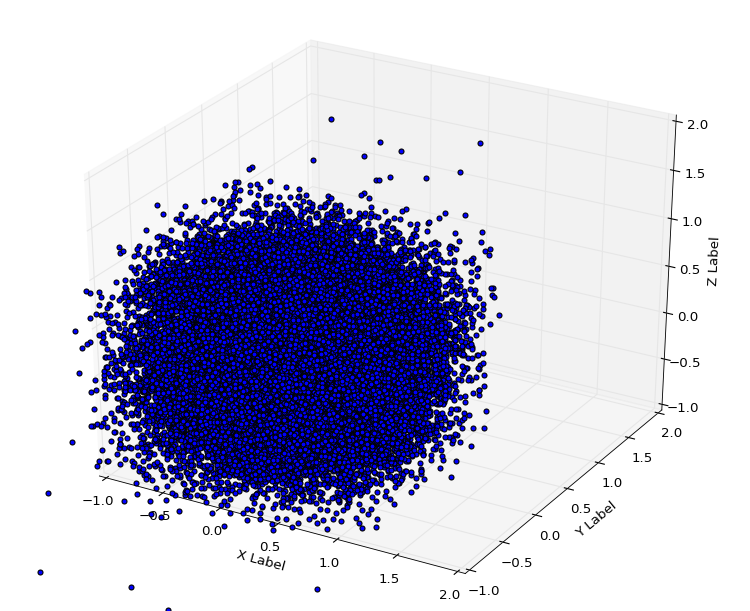

In [123]:
fig = plt.figure()
ax = Axes3D(fig)

for term_index in range(len(informative_terms)):
    #Create a one-hot encoding for our term. It has 0s every where except for a single 1 in the coordinate that corresponds to that term
    term_vector = np.zeros(len(informative_terms))
    term_vector[term_index] = 1
#     print(term_vector)
    #We will now project that one hot vector into the embedding space
    embedding_xyz = np.matmul(term_vector, embedding_matrix)
#     print(embedding_xy)
#     plt.text(embedding_xy[0],
#              embedding_xy[1],
#              informative_terms[term_index])

    ax.scatter(xs=embedding_xyz[0], ys=embedding_xyz[1], zs=embedding_xyz[2])
#     ax.text(x=embedding_xyz[0], y=embedding_xyz[1], z=embedding_xyz[2], s=informative_terms[term_index])
    
    
    #Do a little setup to make sure the plot display nicely
# plt.rcParams['figure.figsize'] = (10,10)
# plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
# plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())

ax.set_xlim3d(-1,2)
ax.set_ylim3d(-1,2)
ax.set_zlim3d(-1,2)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<IPython.core.display.Javascript object>


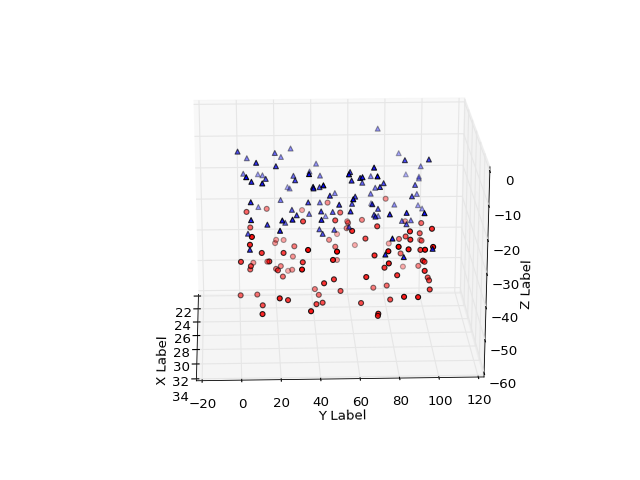

In [121]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()